<a href="https://colab.research.google.com/github/doeungim/ADP_DE/blob/main/ADP_SET_4_DE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import os
import warnings
warnings.filterwarnings('ignore')
# apt-get : 패키지 설치 명령어
# -qq : 에러외의 메세지 숨기는 옵션키
#!apt-get -qq install fonts-nanum

# 한글 꺠짐 필요 라이브러리 불러오기
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 8, 'font.family': 'NanumGothic'}) # 폰트 설정



In [34]:
df = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET4/data/2019.csv')
index = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET4/data/index.csv')

In [42]:
path = os.listdir('/content/drive/MyDrive/ADP_SONY/ADP_SET4/data/')

lst = []
for name in path :
   files = str(name).split('.')[0]
   if len(files) == 4 :
    df = pd.read_csv(f'/content/drive/MyDrive/ADP_SONY/ADP_SET4/data/{name}')
    lst.append(df)

df_total = pd.concat(lst).reset_index(drop = True)

데이터 컬럼 상세 데이터를 바탕으로 출생 데이터 값을 변환한다.

In [43]:
index['항목명'] = index['항목명'].fillna(method = 'ffill')

In [102]:
dics = {}
for part in index['항목명'].unique() :
  target = index[index['항목명'] == part]

  key_value_dic = {}
  for key, value in target.iloc[:,1:].values :
    if key[0] == '0' :
      key_value_dic[str(int(key))] = value

    else :
      key_value_dic[key] = value

  dics[part] = key_value_dic



In [61]:
def convert_to_int(x) :
  # 결측인 경우에는
  if pd.isna(x) :
    return np.nan

  elif isinstance(x, str) :
    return x

  else :
    return str(int(x))

t = df_total.copy()

for col in t.columns :
  # dics에 해당되는 컬럼이 있으면,
  if col in dics.keys() :
    t[col] = t[col].map(convert_to_int)
    t[col] = t[col].map(dics[col])

컬럼에서 미상이 있으면 행을 다 삭제한다.

In [12]:
df1 = t.copy()

# Key 가 columns
for col in dics.keys() :
  df1 = df1[~df1[col].astype('str').str.contains('미상')].reset_index(drop = True)

아래의 조건에 해당하는 각 컬럼의 값이 있다면 해당 행은 제거한다
* 부_교육정도코드 : 학력없음
* 부_각세연령 : 999.0
* 모_교육정도코드 : 학력없음
* 모_각세연령 :999.0
* 실제결혼연도 : 9999.0
* 실제결혼월 : 99.0
* 부모동거기간 : 999
* 모_각세연령 : 50세 이상
* 임신주수 : 0
* 출생아체중: 1kg 이하

In [13]:
remove_dic = {
    '부_교육정도코드' : '학력없음',
    '부_각세연령' : 999.0,
    '모_교육정도코드' : '학력없음',
    '모_각세연령' :999.0,
    '실제결혼연도' : 9999.0,
    '실제결혼월' : 99.0,
    '부모동거기간' : 999,
    '임신주수' : 0
}

for key, value in remove_dic.items() :
  df1 = df1[df1[key] != value].reset_index(drop =True)

df1 = df1[df1['모_각세연령'] < 50].reset_index(drop = True)
df1 = df1[df1['출생아체중'] > 1].reset_index(drop = True)

## EDA

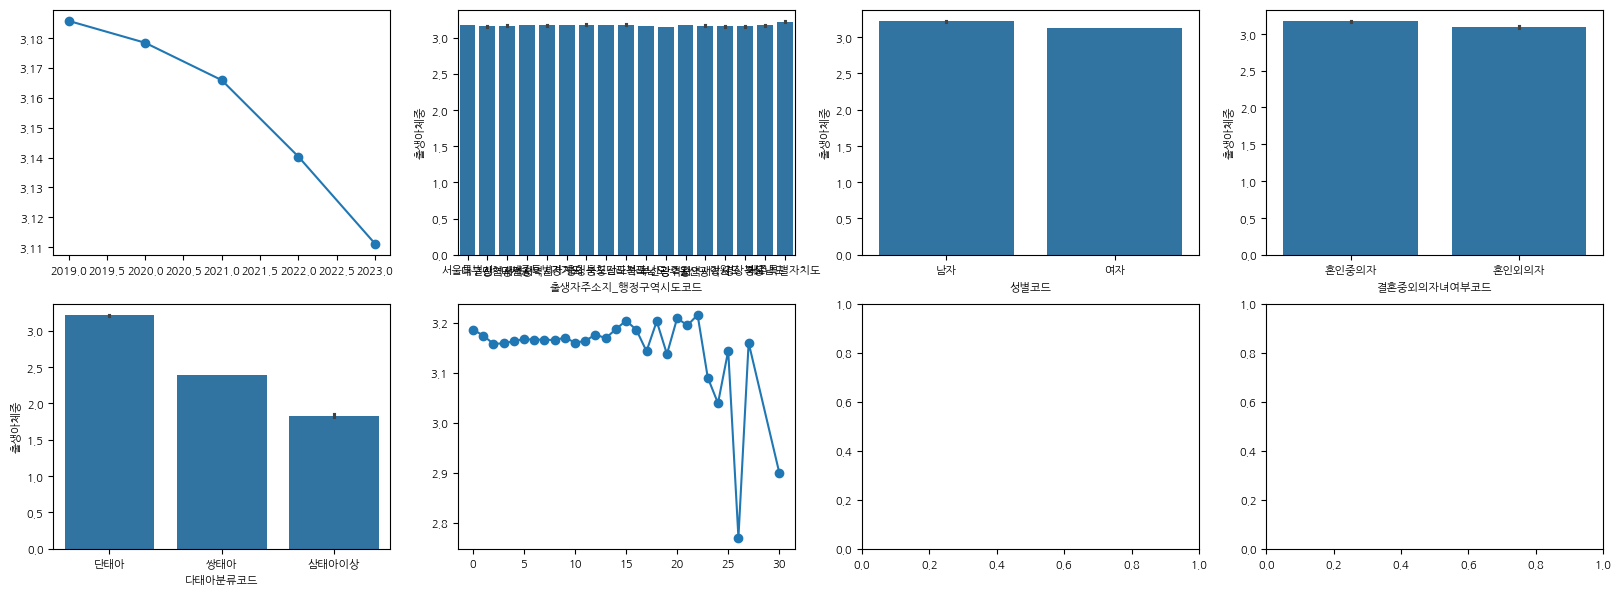

In [14]:
# 출생아 체중 기준으로
import matplotlib.pyplot as plt
import seaborn as sns

cols = [ '신고연도' , '출생자주소지_행정구역시도코드' ,'성별코드', '결혼중외의자녀여부코드', '다태아분류코드' ,'부모동거기간']

fig, axes = plt.subplots(2,4, figsize =( 20, 7))

for i, ax in enumerate(axes.flat[: len(cols)]) :
  col_i = df[cols].columns[i]

  if col_i == '신고연도' :
    target = df1.groupby(['신고연도'])['출생아체중'].mean()
    ax.plot(target.index, target.values, marker = 'o')

  elif col_i == '부모동거기간' :
    target = df1.groupby(['부모동거기간'])['출생아체중'].mean()
    ax.plot(target.index, target.values, marker = 'o')

  else :
    sns.barplot(x = col_i, y = '출생아체중', data = df1, ax = ax)


아래의 기준으로 추가적인 전처리를 실행하고 출생아체중이 각 컬럼들의 값에 따른 차이가 존재하는지 통계 검정을 실시하라

데이터 필터 : 신고월이 2월이며 신고일이 10일 이하 </br>
컬럼제거 : 연도,신고연도,신고월,신고일, 출생자주소지_행정구역시도코드, 결혼중외의자녀여부코드,부_교육정도코드,모_직업분류코드,출생연도,출생월,출생장소코드,실제결혼연도,실제결혼월,모생존아수코드,부_국적코드,모_국적코드,모_국적구분코드,부_국적구분코드

In [15]:
#  데이터 필터
df2 = df1[(df1['신고월'] == 2 ) & (df1['신고일'] <= 10)]

# 컬럼 제거
remove_col = ['연도','신고연도','신고월','신고일', '출생자주소지_행정구역시도코드', '결혼중외의자녀여부코드','부_교육정도코드','모_직업분류코드','출생연도','출생월','출생장소코드','실제결혼연도','실제결혼월','모생존아수코드','부_국적코드','모_국적코드','모_국적구분코드','부_국적구분코드']
df3 = df1[df1.columns.difference(remove_col)]

3에서 전처리한 데이터를 바탕으로 출생아 체중을 예측하는 회귀 모델을 만들려고한다. 아래의 조건에 맞게 모델링을 진행하고 평가하라

성별코드 기준으로 층화추출 진행 (학습데이터 70%, 평가 데이터 30%)
평가기준 rmse
랜덤포레스트, 다중선형회귀 모델로 진행

In [16]:
## 추가 전처리 실행
df3['모_교육정도코드'] = df3['모_교육정도코드'].str.replace(r'[\(\)]', '', regex = True)
df3['모총출생아수코드'] = df3['모총출생아수코드'].str.split('명').str[0].astype(int)

In [22]:
r_df = df3.copy()
cate_cols = r_df.select_dtypes(include = 'object').columns
num_cols  = r_df.select_dtypes(exclude = 'object').columns

In [25]:
from sklearn.preprocessing import LabelEncoder

for col in cate_cols :
  le = LabelEncoder()
  r_df[col] = le.fit_transform(r_df[col])

기계학습4
3에서 전처리한 데이터를 바탕으로 출생아 체중을 예측하는 회귀 모델을 만들려고한다. 아래의 조건에 맞게 모델링을 진행하고 평가하라

- 성별코드 기준으로 층화추출 진행 (학습데이터 70%, 평가 데이터 30%)
- 평가기준 rmse
- 랜덤포레스트, 다중선형회귀 모델로 진행

In [40]:
## 층화추출
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X = r_df.drop(columns = ['출생아체중'], axis = 1)
# Scaling
ss_X = pd.DataFrame(StandardScaler().fit_transform(X) , columns = X.columns)

y = r_df['출생아체중']

x_train, x_test, y_train,y_test = train_test_split(ss_X, y, test_size = 0.3, stratify= ss_X['성별코드'], random_state = 344)


# Linear
lr = LinearRegression()
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)
lr_score = np.sqrt(mean_squared_error(y_test, lr_pred))


# RandomForest
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
rf_score = np.sqrt(mean_squared_error(y_test, rf_pred))

print(lr_score, rf_score)

"""
def rf_model(x_train, y_train) :
  rf = RandomForestRegressor()

  pipeline_rf = Pipeline([
        ('scaler', StandardScaler()),  # 스케일링
        ('rf', RandomForestRegressor(random_state=42))  # 랜덤포레스트 모델
    ])
  pipeline_rf.fit(x_train, y_train)

  return pipeline_rf

rf_pipe = rf_model(x_train, y_train)
pred_rf = rf_pipe.predict(x_test)
rf_score = np.sqrt(mean_squared_error(y_test, pred_rf))


def lr_model(x_train, y_train) :
  lr = LinearRegression()

  pipeline_lr = Pipeline([
        ('scaler', StandardScaler()),  # 스케일링
        ('lr', lr)  # 랜덤포레스트 모델
    ])
  pipeline_lr.fit(x_train, y_train)

  return pipeline_lr

lr_pipe = lr_model(x_train, y_train)
pred_lr = lr_pipe.predict(x_test)
rf_score = np.sqrt(mean_squared_error(y_test, pred_lr))
"""

0.35658445760446245 0.37150464131605404


"\ndef rf_model(x_train, y_train) : \n  rf = RandomForestRegressor()\n  \n  pipeline_rf = Pipeline([\n        ('scaler', StandardScaler()),  # 스케일링\n        ('rf', RandomForestRegressor(random_state=42))  # 랜덤포레스트 모델\n    ])\n  pipeline_rf.fit(x_train, y_train)\n\n  return pipeline_rf\n\nrf_pipe = rf_model(x_train, y_train)\npred_rf = rf_pipe.predict(x_test)\nrf_score = np.sqrt(mean_squared_error(y_test, pred_rf))\n\n\ndef lr_model(x_train, y_train) : \n  lr = LinearRegression()\n  \n  pipeline_lr = Pipeline([\n        ('scaler', StandardScaler()),  # 스케일링\n        ('lr', lr)  # 랜덤포레스트 모델\n    ])\n  pipeline_lr.fit(x_train, y_train)\n\n  return pipeline_lr\n\nlr_pipe = lr_model(x_train, y_train)\npred_lr = lr_pipe.predict(x_test)\nrf_score = np.sqrt(mean_squared_error(y_test, pred_lr))\n"

In [ ]:
"""
lst = {}
model_lst = []

def modelling(model, name) :
  x_train, x_test, y_train,y_test = train_test_split(ss_X, y, test_size = 0.3, stratify= ss_X['성별코드'], random_state = 344)
  model.fit(x_train, y_train)
  pred = model.predict(x_test)
  acc = np.sqrt(mean_squared_error(y_test, pred))
  return {name : acc} , model


for models in (['rf', RandomForestRegressor()], ['lr', LinearRegression]) :
  model = models[0]
  name = models[1]
  acc, model = modelling(model, name)
  lst.update(acc)
  model_lst.append(model)

lst.items()

### 서울 지하철 일별 승하차 인원 데이터

In [3]:
df = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET4/data/subway.csv')
df = df.drop(columns = ['역명','역번호'], axis = 1)
df.head(3)

,날짜,구분,05~06,06~07,07~08,08~09,09~10,10~11,11~12,12~13,...,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24,24~,호선
0,2016-01-01,승차,469,339,584,1144,1723,2087,2983,3527,...,3554,3200,3076,2519,2281,2398,2056,996,58,1
1,2016-01-01,하차,342,1637,1753,1856,2438,2425,2548,2718,...,3108,2656,2134,1859,1394,1344,1056,612,222,1
2,2016-01-01,승차,103,127,110,191,298,582,700,604,...,1339,1458,1499,1383,1284,1198,675,375,9,1


In [16]:
t = df.pivot_table(index = ['날짜','호선'], columns = ['구분'], values = [x for x in df.columns if '~' in x])

lst = []
for time in [x for x in df.columns if '~' in x] :
  ratio = t[(time, '승차')] / t[(time, '하차')]
  ratio.name = f'{time}_ratio'
  lst.append(ratio)


dfs = pd.concat(lst,axis=1).reset_index()

dfs['날짜'] =pd.to_datetime(dfs['날짜'])
dfs['weekend']  = (dfs['날짜'].dt.weekday >=5).astype('int')

In [33]:
# train
#train = dfs[(dfs['날짜'].dt.day % 4) == 1].reset_index(drop = True)
#test = dfs[(dfs['날짜'].dt.day % 4) != 1].reset_index(drop = True)

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, mean_squared_error

test = dfs[dfs['날짜'].dt.year ==2017].reset_index(drop=True).drop(columns ='날짜')
train = dfs[dfs['날짜'].dt.year ==2016].reset_index(drop=True).drop(columns ='날짜')

x_train = train.drop(columns = ['호선'], axis = 1)
y_train = train['호선']

x_test = test.drop(columns = ['호선'], axis = 1)
y_test = test['호선']

lst = {}
model_lst = []

def modelling(model, name, x_train, x_test, y_train, y_test):
  model.fit(x_train, y_train)  # 모델 학습
  pred = model.predict(x_test)
  acc = np.sqrt(mean_squared_error(y_test, pred))
  return {name : acc} , model

for models in (['RandomForest' , RandomForestClassifier()], ['Decision Tree', DecisionTreeClassifier()]) :
  model = models[0]
  name = models[1]
  acc, model = modelling(name, model, x_train, x_test, y_train, y_test)
  lst.update(acc)
  model_lst.append(model)

pd.DataFrame(lst.items() , columns = ['Model', 'F1-score'])

,Model,F1-score
0,RandomForest,0.030220
1,Decision Tree,0.138485


한 카페에서는 고객들이 음료를 주문한 후, 음료가 준비되는 시간을 추적한다.
음료 준비 시간은 평균이 5분이고, 표준편차가 1.5분인 정규분포를 따른다.

* 특정 고객이 음료를 6분 이내에 받을 확률은?
* 3분에서 7분 사이에 음료가 준비될 확률은?
* 10명의 고객 중, 6분 이내에 음료를 받을 고객이 3명 이상일 확률은?

In [68]:
import scipy.stats as stats

x = 5
s = 1.5

# 1. 6분 이내에 받을 확률
minute_6 = stats.norm.cdf(6, x, s)
print(f"특정 고객이 음료를 6분 이내에 받을 확률은 {round(minute_6, 2)}")

# 2. 3분에서 7분 사이
minut_3_7 =  stats.norm.cdf(7, x, s) -  stats.norm.cdf(3, x, s)
print(f"3분에서 7분 사이에 음료가 준비될 확률 {round(minut_3_7, 2)}")

# 3. 10명 중 6분 이내의 고객이 3명 이상 (1 - cdf(3-1))
n = 10
p = minute_6
prob3 = 1 - stats.binom.cdf(2, n, p)
print(f"10명의 고객 중, 6분 이내에 음료를 받을 고객이 3명 이상일 확률 {prob3:.4f}")

특정 고객이 음료를 6분 이내에 받을 확률은 0.75
3분에서 7분 사이에 음료가 준비될 확률 0.82
10명의 고객 중, 6분 이내에 음료를 받을 고객이 3명 이상일 확률 0.9996


한 레스토랑에서 두 명의 셰프(A와 B)가 준비한 요리에 대한 고객들의 만족도를 조사했다.
각 셰프가 준비한 요리에 대해 10명의 고객이 점수를 매겼다. 점수는 1점부터 10점까지이며, 점수가 높을수록 만족도가 높음을 의미한다.
두 셰프의 요리에 대한 고객 점수가 정규분포를 따르지 않는다고 가정하고, 셰프 A와 셰프 B의 요리에 대해 고객들의 만족도가 차이가 나는지 비모수 검정을 통해 확인하라

In [69]:
from scipy.stats import wilcoxon

# 셰프 A와 셰프 B의 고객 점수
A = np.array([7, 8, 9, 5, 6, 7, 8, 6, 7, 9])
B = np.array([6, 5, 8, 7, 6, 5, 6, 4, 7, 5])

stat, p_val = wilcoxon(A, B)
print(f"검정 통계량 {stat},  p-value는 {p_val} 이며")


검정 통계량 4.5,  p-value는 0.05531569013519519


In [87]:
import numpy as np

# 주어진 확률들
P_D = 0.02        # 질병이 있을 확률
P_not_D = 0.98    # 질병이 없을 확률

P_X_pos_D = 0.73  # 질병이 있을 때 검사 X가 양성일 확률
P_X_pos_not_D = 0.10  # 질병이 없을 때 검사 X가 양성일 확률

P_Y_pos_D = 0.66  # 질병이 있을 때 검사 Y가 양성일 확률
P_Y_pos_not_D = 0.05  # 질병이 없을 때 검사 Y가 양성일 확률

# 1) X, Y 가 모두 양성일때, 실제로 질병을 가질 확률
# X,Y 양성 & 질병 : P(X: 양성 , Y: 양성 | 질병) = P(X 양성 | 질병) * P(Y 양성 | 질병)
xy_positive_do = P_X_pos_D * P_Y_pos_D

# 2) X,Y 양성 & 질병없음 : P(X 양성 , Y 양성 | 질병없음) = P(X 양성 | 질병없음) * P(Y 양성 | 질병없음)
xy_positive_dx = P_X_pos_not_D * P_Y_pos_not_D

# 3) X,Y 양성 : (X,Y 양성 | 질병) * P(질병) +  P(질병) + P(X 양성, Y 양성 | 질병 없음) * P(질병 없음)
xy_positive = (xy_positive_do * P_D )+ (xy_positive_dx * P_not_D)

# 4) P(질병 | X,Y 양성) = P(X,Y 양성 | 질병) * P(질병) + P(X 양성, Y 양성 | 질병 없음) * P(질병 없음)
#  질병에 있을때의 x,y 양성 / 모든 양성
d_xy_positive = (xy_positive_do * P_D) / xy_positive
print(d_xy_positive)


0.662905888827738


검사 X가 양성이고 검사 Y가 음성일 때, 환자가 실제로 질병을 가질 확률은 얼마인가?

In [88]:

# 1) 질병이 있을 때
# P(X: 양성. Y : 음성 | 질병) = P(X: 양성|질병) * 1 - P(Y 양성|질병)
x_positive_y_negative_yd = P_X_pos_D * (1 - P_Y_pos_D )

# 2) 질병이 없을 때
# P(X: 양성. Y : 음성 | 질병없음) = P(X 양성 | 질병없음) * (1 - P(Y 양성|질병없음))
x_positive_y_negative_nd = P_X_pos_not_D * (1 - P_Y_pos_not_D)

# P(X 양성, Y 음성) = P(X 양성, Y 음성 | 질병) * P(질병) + P(X 양성, Y 음성 | 질병 없음) * P(질병 (없음)
xp_yn = (x_positive_y_negative_yd * P_D) +( x_positive_y_negative_nd * P_not_D)

# P(질병| X 양성 Y 음성) = P(X 양성 Y 음성 | 질병) * P(질병) / P(X 양성 Y 음성)
d_xp_yn = ( x_positive_y_negative_yd* P_D) / xp_yn
print(d_xp_yn)

0.05062000326317507


검사 Y가 양성일 때, 검사 X가 음성일 확률은?

In [100]:
# P(Y 양성, X 음성 | 질병) = P(Y 양성|질병) * (1 - P(X 양성|질병))
yp_xn_yd = P_Y_pos_D * (1 - P_X_pos_D)

# P(Y 양성, X 음성 | 질병없음) = P(Y 양성|질병없음) * (1 - P(X 양성|질병없음))
yp_xn_nd = P_Y_pos_not_D * (1 - P_X_pos_not_D)

# P(Y 양성, X 음성) = P(Y 양성, X 음성 | 질병) * 질병 + # P(Y 양성, X 음성 | 질병없음) + 질병없음
xy_positive = (yp_xn_yd * P_D ) + (yp_xn_nd * P_not_D)

# P(X 음성 | Y 양성) = P(양성) * P(Y 양성 |  X 음성) / P(Y 양성)
# Y 양성 = 질병 * 양성  + 질병없음 * 양성
y_positive = (P_Y_pos_D * P_D ) + (P_Y_pos_not_D * P_not_D)


xy_positive / y_positive

0.7663022508038585